# Objective: Predict the national origin of a surname with an NLP model

***This problem is a very hard one to unpack, so I will start with only three national origins and start my model building there; Spanish, German, and French. Thus, my model's predictions will live in a universe where a name can only be Spanish, German or French. This rolls back some of the complexity for now and will allow me to classify three nationalities well.***

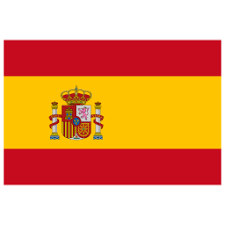

In [526]:
import IPython

url = 'https://user-images.githubusercontent.com/58672183/74598570-9ddfaf00-5041-11ea-87a4-636d9a8a2b3c.png'
IPython.display.Image(url, width = 250)

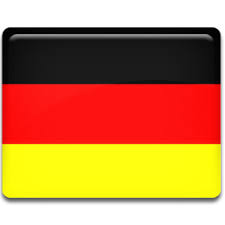

In [527]:
url = 'https://user-images.githubusercontent.com/58672183/74598567-98826480-5041-11ea-97e8-077e6d657539.jpg'
IPython.display.Image(url, width = 250)

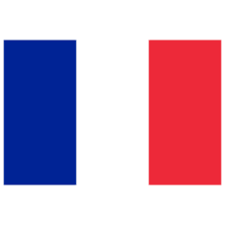

In [528]:
url = 'https://user-images.githubusercontent.com/58672183/74598564-8f919300-5041-11ea-8901-ad9ce95f833c.png'
IPython.display.Image(url, width = 250)

In [393]:

from __future__ import unicode_literals # unicode handling
import pandas as pd
import numpy as np
import scipy as sp
import json
import spacy # pre-processing and traditional NLP stemming
import codecs # unicode handling
from scipy.sparse import hstack # stack arrays in sequence horizontally
from gensim.models.word2vec import Word2Vec # Gensim is used for LDA and word2vec
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer # information retrieval
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA # principal component analysis
from sklearn import metrics

***Background: What's in a Name?***

I think it's appropriate to start at a website that talks about family history and where names came from!

https://www.familyeducation.com/

You can browse this website for various info about family history, but the section I'm concerned with is the browse origin surname section.

https://www.familyeducation.com/baby-names/browse-origin/surname

You can see the list of countries where there are surnames available. For each country, there is also a short description of how names were derived. For example, the German description says:

_It wasn't until 1871 that Germany became a unified country. Until then, it was made up of smaller nation-states whose borders frequently changed. Even after 1871, Germany's land area and political influence shifted several times. Because of this, German last names can be found throughout bordering countries, including Poland, Austria, France and Spain._

_Another tricky thing about German last names: A last name could be what you would call a farm name. If a German moved onto someone else's farm, it was not uncommon to change his last name to that of the farm. If his wife inherited a farm, he might change his name to her maiden name._

Surnames are often derived from a place of origin, an activity or a profession that defined a family. Place names in turn could originate from landmarks or features that defined a town or city. Thus, many surnames have roots in actual words from the spoken language of the region. (Or perhaps, the medieval version of the language.) This is an important fact that will come up later in the analysis.

For now, I just want to give some examples of some specific surnames and their origins.

    Beaumont (French) - From French place names derived from beau "beautiful" and mont "mountain".

    Boucher (French) - Means "butcher" in French.

    Ojeda (Spanish) - From the name of the Ojeda river in Soria, Spain, possibly derived from Latin folia "leaves".

    Herzog (German) - From a German title meaning "duke", a nickname for a person who either acted like a duke or worked in a duke's household.
    
Not all surnames have origins that are this clear. For example, many surnames may just be derived from given names. These given names may or may not have roots in the region. For example, the surname "Alberto" may be nominally Spanish, but it's derived from the given name "Albert" which stems from the old Germanic name "Adalbert", meaning noble and bright.

Certainly, there are many layers of complexity to unpack here! Hopefully, our NLP model will be able to take everything into account to predict the nationality of previously unseen surnames accurately. We will be training it on a dataset collected from Familyeducation and see what kind of accuracy it achieves.




***Collecting the Dataset***

Familyeducation has the German, French, and Spanish surnames sorted on their site, but not in a csv format for easy downloading. Collection just requires using a web scraping script. The following was the script used to web scrape all of the French surnames from the website.

In [ ]:
from selenium import webdriver
import pandas as pd
import time


df = pd.read_csv(r'C:\Users\Daniel_Heffley\Desktop\Predict Good Matches\Surnames DF.csv')#Dataframe used to store scraped names

driver = webdriver.Chrome(executable_path=r'C:\Users\Daniel_Heffley\Desktop\chrome driver\chromedriver.exe')#Executable for Selenium

driver.get('chrome://settings/content/images')#Turn off images in settings for faster page loading
time.sleep(0.5)
input('Unselect image loading and then hit ENTER in this terminal')#Manually done by user and then hit enter to proceed



all_names = []#Instatiate list of surnames

for i in range(0,37):#The surnames are spread across 37 webpages

    url = r'https://www.familyeducation.com/baby-names/browse-origin/surname/french?page=' + str(i)#Create URL

    driver.get(url)#Load page

    names_on_page_objects = driver.find_elements_by_css_selector('li')#The names are stored in the 'li' class on the webpages


    for i in names_on_page_objects:
        all_names.append(i.text)#Get the text property from the 'li' class objects and store in the list
    
    

u = 0
for name in all_names:
    df.loc[u,'Name'] = name #place the names from the list in the dataframe
    u = u + 1

df.to_csv(r'C:\Users\Daniel_Heffley\Desktop\Predict Good Matches\surnames FR.csv')

After webscraping the French, German, and Spanish surnames, a csv with all of them collected together is produced.

***EDA***

In [401]:
surnames = pd.read_csv(r'C:\Users\Daniel_Heffley\Desktop\Predict Good Matches\Surnames DF.csv')

After loading in the surnames, we can see what the dataframe looks like. 

The classes are: 

    Class 0: German 
    Class 1: French
    Class 2: Spanish

In [402]:
surnames[surnames['Class'] == 0].head()

,Name,Class
0,Abbas,0
1,Abbe,0
2,Abegglen,0
3,Abel,0
4,Abeln,0


In [403]:
surnames[surnames['Class'] == 1].head()

,Name,Class
12275,Abbe,1
12276,Acord,1
12277,Acy,1
12278,Adrien,1
12279,Agard,1


In [404]:
surnames[surnames['Class'] == 2].head()

,Name,Class
15287,Abad,2
15288,Abalos,2
15289,Abar,2
15290,Abascal,2
15291,Abeita,2


In [405]:
surnames.shape

(17248, 2)

In [406]:
surnames.Class.value_counts()

0    12275
1     3012
2     1961
Name: Class, dtype: int64

Right off the bat, the first thing we notice is that there are far more German surnames than French or Spanish ones. This is just due to the fact that the website lists many more German names. This could perhaps be problematic for the model as it could be biased to labeling a name German since so much of the traning data is German. I won't address this for now as I would rather have more data than cull some of the German data. We will see how this works out.

Something else you may have noticed in the dataframe heads shown above is that "Abbe" is in the German and French class. This goes back to my point before about how some surnames come from multi-regional given names. But for modeling purposes, we will want to avoid a name that is in more than one class. We will just clear any duplicates from the dataset.

In [407]:
surnames.drop_duplicates(subset=['Name'], keep=False, inplace = True)

In [408]:
surnames.Class.value_counts()

0    12098
1     2812
2     1895
Name: Class, dtype: int64

After dropping the duplicates, we can see that the German names make up about 72% of the dataset. Therefore, we're looking at a baseline accuracy for our model of 0.72.

In [409]:
12098/(2812 + 1895 + 12098)

0.7199047902409997

One last thing to note is that the data on the website did not contain any non-English characters. So, there are no umlauts or accent marks to consider. For example, the German name "Müller" appears as "Muller" in the dataset.

In [410]:
surnames.shape

(16805, 2)

***Creating the Model***

In [411]:
X = surnames.Name #We create the feature and target
y = surnames.Class

# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size = .1)

Usually, NLP models rely on word level tokens to create Count Vector or Term Frequency - Inverse Document Frequency matrices. As surnames are usually one word, this approach would not be helpful in our use case. This is where the custom analyzer comes into play. The function below is used to tokenize the surnames into tokens of size 2. So, we are basically creating "words" from the surnames by splitting them into tokens of size 2.

In [412]:
import re

def ngrams(string, n=2):
    string = re.sub(r'[,-./]|\sBD',r'', string)#This step just does some string cleaning
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

Here is a quick example of how the function works.

In [413]:
ngrams('muller')

['mu', 'ul', 'll', 'le', 'er']

We use a Term Frequency - Inverse Document Frequency (Tfidf) vectorizer with the custom ngram function from above as the analyzer. The hope is that certain 2-ngrams are more common in surnames from one country than the others. The advantage of using the Tfidf matrix is that it will be able to give less weight to very common 2-ngrams across the whole dataset.

After obtaining the document term matrices, we use a Random Forest Classifier to pick the features that are most important for classifying surnames. The model had better performance when n_estimators was set to 100 and max_features was set to log2 instead of the default.

In [414]:
vect = TfidfVectorizer(analyzer = ngrams)

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# Use Random Forest classifier to predict the class of the name
rf = RandomForestClassifier(n_estimators = 100, max_features = 'log2')
rf.fit(X_train_dtm, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

We can now create a new dataframe with the test data and the predicted class output.

In [415]:
test_results = pd.DataFrame(columns = ['Name','class','class_pred'])

In [416]:
test_results['Name'] = X_test

In [417]:
test_results['class'] = y_test

In [418]:
test_results['class_pred'] = rf.predict(X_test_dtm)

In [420]:
test_results.to_csv('test_results_surnames.csv')

The prediction accuracy is almost 89% for our test data. This is above the baseline accuracy of 72%.

In [421]:
metrics.accuracy_score(y_test, rf.predict(X_test_dtm))

0.8863771564544913

***Model Analysis***

Let's look deeper into the predictions that the model produces. It is mostly predicting the test data correctly, but let's take a look at a selection of incorrect predictions.

Reminder, the classes are: 

    Class 0: German 
    Class 1: French
    Class 2: Spanish

In [436]:
test_results[test_results['class'] != test_results['class_pred']].head(20)

,Name,class,class_pred
13371,Duhamel,1,0
15103,Theodore,1,0
16826,Renderos,2,0
15248,Vibert,1,0
12335,Armand,1,0
12540,Bergeron,1,0
13303,Dore,1,0
15126,Thill,1,0
14221,Madore,1,2
24,Adami,0,2


As I foreshadowed before, the predictions look to be at least a little biased towards picking German (class 0). We can very clearly see this bias though when we look at the prediction probalities.

In [441]:
rf.predict_proba(vect.transform(['Vibert']))#French name
#The first column in the output is German probability, the second French, and the third Spanish
#French nearly won out over German here

array([[0.46, 0.44, 0.1 ]])

In [439]:
rf.predict_proba(vect.transform(['Leyba']))#Spanish name
#The model was fairly confident it was German though

array([[0.69, 0.19, 0.12]])

There were certainly cases though where the prediction was Spanish or French and the name was not.

In [444]:
rf.predict_proba(vect.transform(['Adami']))#German name
#Predicted as Spanish; though to my ear this doesn't "sound" very German. Maybe I can cut my model some slack haha

array([[0.45, 0.05, 0.5 ]])

Perhaps the best way of seeing the model's bias towards German is to just feed it short, non-sensical strings and see the probabilities.

In [449]:
rf.predict_proba(vect.transform(['Pi']))

array([[0.67, 0.3 , 0.03]])

In [447]:
rf.predict_proba(vect.transform(['P']))

array([[0.97, 0.03, 0.  ]])

In [448]:
rf.predict_proba(vect.transform(['']))

array([[0.97, 0.03, 0.  ]])

It's problematic to see the blank string returning with a 97% probabality of being German. (Though ironically fitting, as the Germans aren't historically known for chit-chat haha) I think this is an area where the model could use some tuning in the future.

***Applying the Model to Real Words in These Languages*** 

Perhaps this model could be extended beyond just predicting the nationality of names. It could also be useful for predicting the actual language of the words in a text. As I alluded to before, surnames are often based on actual words in a given language. Thus, the ngrams we created to parse surnames should be similar to the ngrams created if we parsed entire blocks of text in a given language. 

To test out this theory, I input the sentence "How many times must I say" in French, German, and Spanish into the model and output the predictions.

In [458]:
rf.predict(vect.transform(['Combiendefoisdois-jedire','Wieoftmussichsagen','Cuantasvecesdebodecir']))

array([1, 0, 2], dtype=int64)

It was right all three times. This made me think it could predict even longer texts.

In [456]:
spanish_text = 'Formado como futbolista desde categoría alevín en la cantera del Atlético de Madrid, debutó con el primer equipo rojiblanco en 2001 con 17 años, consiguiendo el ascenso la siguiente temporada a Primera División.'

In [467]:
rf.predict_proba(vect.transform([spanish_text])) #predicted to be Spanish with a 50% probablity.

array([[0.36, 0.14, 0.5 ]])

In [459]:
german_text = 'Torres spielte bereits sechs Jahre in den Jugendmannschaften von Atlético Madrid, bevor er Profispieler wurde. 1998 gewann er mit seinem Nachwuchsteam ein internationales Turnier, das von dem Sportartikelhersteller Nike veranstaltet wurde.'

In [466]:
rf.predict_proba(vect.transform([german_text])) #predicted to be German with a 74% probablity.

array([[0.74, 0.04, 0.22]])

In [461]:
french_text = "Torres participe à la remontée de l'Atlético Madrid et inscrit 13 buts lors de sa première saison dans l'élite, à l'âge de 19 ans. Attaquant précoce, il est déjà capitaine de l'équipe. Doté d'un jeu de tête et d'un sens du but remarquable pour son âge"

In [463]:
rf.predict_proba(vect.transform([french_text])) #predicted to be French with a 50% probablity.

array([[0.12, 0.5 , 0.38]])

It is noteworthy that even with these longer texts, the German bias is still observed with the probabilites for the Spanish and French texts being lower than the German text.

As one final test, let's see how it predicts a non target language text.

In [464]:
italian_text = "L'anno successivo la squadra viene promossa nella Liga. Nella sua prima stagione nel massimo campionato spagnolo Torres ha giocato 29 partite e realizzato 13 gol. Nella stagione 2003-2004 Torres, a 19 anni, è stato nominato capitano"

In [468]:
rf.predict_proba(vect.transform([italian_text])) #predicted to be Spanish with a 64% probablity.

array([[0.22, 0.14, 0.64]])

It's a little ironic that it predicts the Italian text to be Spanish with a higher probability than it predicted the Spanish text to be Spanish. Nonetheless, it still makes sense given that Italian is most similar to Spanish out of the three target languages.

***Conclusion***

The model predicts the nationality of previously unseen surnames correctly about 89% of the time at present. Some tuning of the hyperparamters or the dataset could help increase this number. This model could really never be perfect as there are some surnames that defy good classification, such as the ones that can be multiple nationalities. It is interesting though that the model seems to predict the language of a given text pretty well despite the fact it was not trained on any data that contained actual words from the given language. In a future test, I may even want to test this idea further. It seems like it could perform well given that longer texts have more ngrams and thus more chances to display ngrams that are more common to one language than another.

To give some credence to the point about longer texts having more accurate predictions, here is a breakdown of the average string length of incorrect predictions versus correct predictions.

In [520]:
wrong_predictions = test_results[test_results['class'] != test_results['class_pred']]#Create wrong prediction dataframe

In [521]:
right_predictions = test_results[test_results['class'] == test_results['class_pred']]#Create right prediction dataframe

In [522]:
wrong_predictions.reset_index(inplace = True)
i = 0
wrong_predictions_string_len = []
for i in range(wrong_predictions.shape[0]):
    length_of_string = len(str(wrong_predictions.loc[i,'Name']))
    wrong_predictions_string_len.append(length_of_string)
    i = i + 1
    
print('Incorrect predictions have an average string length of',round(np.mean(wrong_predictions_string_len),2))

Incorrect predictions have an average string length of 5.96


In [523]:
right_predictions.reset_index(inplace = True)
i = 0
right_predictions_string_len = []
for i in range(right_predictions.shape[0]):
    length_of_string = len(str(right_predictions.loc[i,'Name']))
    right_predictions_string_len.append(length_of_string)
    i = i + 1
    
print('Correct predictions have an average string length of', round(np.mean(right_predictions_string_len),2))

Correct predictions have an average string length of 6.74


Correctly predicted surnames are almost a full letter longer on average than incorrectly predicted surnames. This is what is expected given that longer surnames have more ngrams and thus more chances to display features that are more common to one language.

***Appendix***

In [496]:
right_predictions[(right_predictions['class'] == 0) == True].shape[0] #number of correct German predictions

1159

In [497]:
wrong_predictions[(wrong_predictions['class'] == 0) == True].shape[0] #number of incorrect German predictions

28

In [498]:
right_predictions[(right_predictions['class'] == 1) == True].shape[0] #number of correct French predictions

191

In [499]:
wrong_predictions[(wrong_predictions['class'] == 1) == True].shape[0] #number of incorrect French predictions

104

In [501]:
right_predictions[(right_predictions['class'] == 2) == True].shape[0] #number of correct Spanish predictions

140

In [502]:
wrong_predictions[(wrong_predictions['class'] == 2) == True].shape[0] #number of incorrect Spanish predictions

59

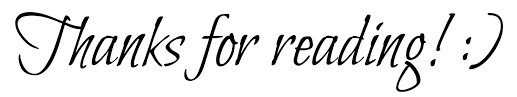

In [529]:
url = 'https://user-images.githubusercontent.com/58672183/74598595-e72ffe80-5041-11ea-80bc-483869696cc4.png'
IPython.display.Image(url, width = 250)